# Overfitting, Underfitting, Early Stopping, Weight Initialization

Сегодня мы с вами увидим, как недообучение и переобучение выглядят в терминах нейронных сетей и что можно сделать для того, чтобы решать эти проблемы.  
Давайте проверим, что у нас установлены все необходимые нам пакеты, в т.ч. seaborn - пакет для визуализации, который мы будем использовать.

In [1]:
!pip install numpy tensorflow tensorflow_datasets seaborn pandas matplotlib

Далее импортируем все пакеты, которые будем использовать.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics, layers, activations, optimizers, losses
import tensorflow_datasets as tfds
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(18, 5)})

Для лучшей воспроизводимости данного ноутбука зафиксируем все random seed, которые могут использоваться.

In [3]:
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Мы будем использовать тот же самый набор данных ирисов Фишера, что и ранее, поэтому импортируем его и подготовим, как и ранее, для работы.

In [4]:
ds_train, ds_test = tfds.load(
    name='iris',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True
)

input_shape = (4, )  
batch_size = 10      
amount_of_classes = 3

def make_one_hot(x, y):
    return x, tf.one_hot(y, depth=amount_of_classes)

ds_train = (
    ds_train
    .map(make_one_hot)
    .shuffle(len(ds_train))
    .batch(batch_size, drop_remainder=True)
)
    
ds_test = (
    ds_test
    .map(make_one_hot)
    .batch(batch_size, drop_remainder=True)
)

Underfitting (недообучение) - это ситуация, когда модель, которой мы пытаемся приблизить искомую функцию, не обладает достаточной сложностью для адекватного описания набора данных. Вы наверняка уже сталкивались с данной ситуацией, работая ранее с другими моделями машинного обучения - например, пытаясь предсказать линейной функцией какие-либо сложные зависимости в данных.  

В мире нейронных сетей данная ситуация тоже имеет место быть. Обычно это случается тогда, когда вычислительной мощности сети недостаточно для описания зависимостей в данных и сеть находит лишь наиболее простые зависимости и условия, которые дают хороший результат, но недостаточно точный. Для примера давайте создадим сеть из двух слоев, в одном из которых только один нейрон, а на выходе - количество, равное количеству классов, и попытаемся обучить данную модель на нашем наборе данных.

In [5]:
model = keras.Sequential()
model.add(layers.Dense(1, input_shape=input_shape, activation='sigmoid'))
model.add(layers.Dense(amount_of_classes, activation='softmax'))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)

history = model.fit(ds_train, epochs=30, validation_data=ds_test, verbose=1)

Epoch 1/30
12/12 [==============================] - 1s 39ms/step - loss: 1.0457 - categorical_accuracy: 0.3250 - val_loss: 0.9859 - val_categorical_accuracy: 0.3667
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.9239 - categorical_accuracy: 0.50 - 0s 10ms/step - loss: 0.9802 - categorical_accuracy: 0.4333 - val_loss: 0.9585 - val_categorical_accuracy: 0.6667
Epoch 3/30
12/12 [==============================] - 0s 10ms/step - loss: 0.9496 - categorical_accuracy: 0.6417 - val_loss: 0.9295 - val_categorical_accuracy: 0.6000
Epoch 4/30
12/12 [==============================] - 0s 8ms/step - loss: 0.9174 - categorical_accuracy: 0.5167 - val_loss: 0.9004 - val_categorical_accuracy: 0.6333
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 0.8856 - categorical_accuracy: 0.4417 - val_loss: 0.8733 - val_categorical_accuracy: 0.5000
Epoch 6/30
12/12 [==============================] - 0s 10ms/step - loss: 0.8580 - categorical_accuracy: 0.6750 - val_loss: 

Визуализируем графики значений функции потерь и точности. Для этого преобразуем историю обучения в новый датафрейм и построим соответствующие граифики с помощью пакета seaborn.

(0.0, 1.0)

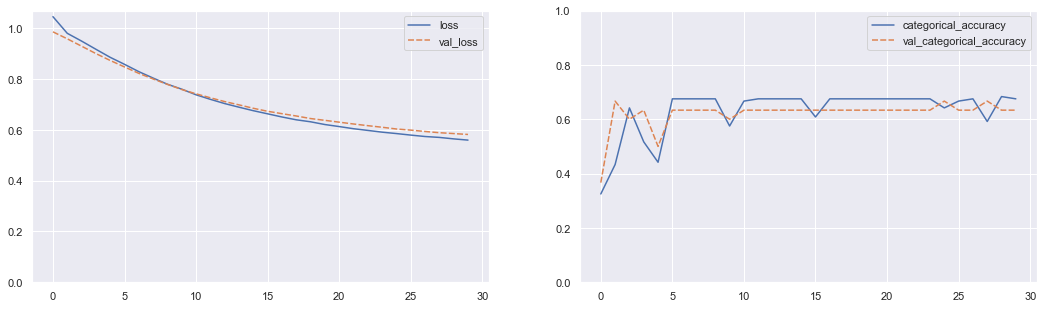

In [6]:
df = pd.DataFrame(history.history)

f, axes = plt.subplots(1, 2)

ax = sns.lineplot(data=df[['loss', 'val_loss']], ax=axes[0])
ax.set_ylim(0)

ax = sns.lineplot(data=df[['categorical_accuracy', 'val_categorical_accuracy']], ax=axes[1])
ax.set_ylim(0, 1)

Как можно заметить, точность модели достигла примерно 0.7 на тренировочном и валидационном наборе данных. Ранее в данном курсе мы с вами видели, что модель может достигать более высокого качества и в данном случае мы с вами наблюдам ситуацию недообучения модели. Недообучение, в том числе, может происходить и в том числе при недостаточном количестве эпох обучения, слишком маленьком коэффициенте обучения, или неправильно выбранной архитектуре сети.

В данном случае правильным решением будет постепенно увеличивать сложность сети, наращивая ее глубину и мощность и повышая качество полученной модели.  

Тем не менее, если мы попробуем сразу использовать слишком сильную и сложную сеть, мы можем столкнуться с фактом переобучения модели. Несмотря на то, что на таком простом наборе данных этого достичь достаточно сложно, давайте попробуем это сделать. 

In [7]:
model = keras.Sequential()
model.add(layers.Dense(128, input_shape=input_shape, activation='sigmoid'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dense(16, activation='sigmoid'))
model.add(layers.Dense(amount_of_classes, activation='softmax'))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)


history = model.fit(ds_train, epochs=60, validation_data=ds_test, verbose=1)

Epoch 1/60
12/12 [==============================] - 1s 30ms/step - loss: 1.1086 - categorical_accuracy: 0.3417 - val_loss: 1.1045 - val_categorical_accuracy: 0.3000
Epoch 2/60
12/12 [==============================] - 0s 10ms/step - loss: 1.1010 - categorical_accuracy: 0.3417 - val_loss: 1.1031 - val_categorical_accuracy: 0.3000
Epoch 3/60
12/12 [==============================] - 0s 10ms/step - loss: 1.1023 - categorical_accuracy: 0.2833 - val_loss: 1.0929 - val_categorical_accuracy: 0.3667
Epoch 4/60
12/12 [==============================] - 0s 11ms/step - loss: 1.0953 - categorical_accuracy: 0.3250 - val_loss: 1.0915 - val_categorical_accuracy: 0.6667
Epoch 5/60
12/12 [==============================] - 0s 11ms/step - loss: 1.0908 - categorical_accuracy: 0.6833 - val_loss: 1.0914 - val_categorical_accuracy: 0.6333
Epoch 6/60
12/12 [==============================] - 0s 10ms/step - loss: 1.0870 - categorical_accuracy: 0.6750 - val_loss: 1.0876 - val_categorical_accuracy: 0.6333
Epoch 7/60

Аналогичным образом визуализируем полученные результаты.

(0.0, 1.0)

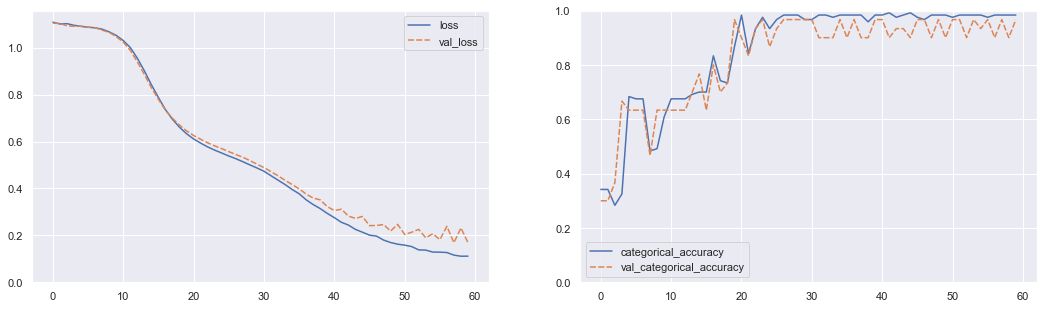

In [8]:
df = pd.DataFrame(history.history)

f, axes = plt.subplots(1, 2)

ax = sns.lineplot(data=df[['loss', 'val_loss']], ax=axes[0])
ax.set_ylim(0)

ax = sns.lineplot(data=df[['categorical_accuracy', 'val_categorical_accuracy']], ax=axes[1])
ax.set_ylim(0, 1)

Как можно заметить, в какой-то момент точность нашей модели на тренировочной выборке стала больше, чем на валидационной. В зависимости от величины расхождения, это - один из хороших показателей того, что ваша модель переобучается на заданный набор данных. Переобучение, как и в классическом машинном обучении, может привести к тому, что модель запомнит обучающий набор данных и потеряет генерализующую способность - т.е. не сможет адекватно оценивать и корректно классифицировать новые экземпляры данных, которые она до этого не видела.  

В нейронных сетях кроме метрик на тренировочном и валидационном наборе данных также хорошим показателем того, произошло ли переобучение модели, является график функции потерь. До тех пор, пока график функции потерь на валидационном наборе данных является ниспадающим, модель учится и находит зависимости в данных, которые полезны для всего набора данных - именно поэтому снижается значение функции потерь, ведь на валидационном наборе данных модель тоже показывает улучшающиеся результаты.  

В тот момент, когда графики функций потерь тренировочного и валидационного набора данных начинают расходиться, в этот момент дальнейшее обучение менее полезно с т.з. генерализующей способности, т.к. модель начинает выучивать данные вместо обобщения, что выражается в том, что на тренировочном наборе данных значение функции потерь продолжает падать, а на валидационном - нет. Это можно заметить на текущем графике функций потерь.

В дальнейшем, при продолжении обучения, возможна следующая ситуация - значения функции потерь на тренировочном наборе данных продолжают падать, а на валидационном - начинают расти. В этот момент модель "начала учиться не туда" - т.е. модель начинает терять генерализующую способность и уже точно стоит прекратить обучение.

Таким образом, одним из оптимальных решений будет остановка обучения в тот момент, когда значение функции потерь на валидационном наборе данных перестанет снижаться. В фреймворке Keras для этого присутствует т.н. EarlyStopping Callback - специальный объект, который останавливает обучение при выполнении данного условия. Кроме него, в фреймворке присутсвует еще множество других callback'ов, на которые стоит обратить внимание - например, промежуточное сохранение модели в процессе обучения для гарантии того, что результат не потеряется в случае перебоев питания компьютера, или callback отсылки информации на удаленный сервер.

Инициализируем EarlyStoppingCallback, укажем `val_loss` как значения для мониторинга и запустим процесс обучения предыдущей модели заново.

Epochs executed: 55


(0.0, 1.0)

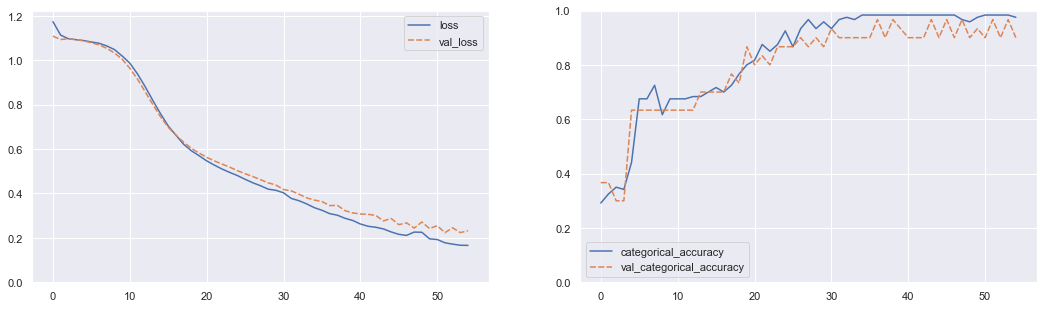

In [9]:
esc = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model = keras.Sequential()
model.add(layers.Dense(128, input_shape=input_shape, activation='sigmoid'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dense(16, activation='sigmoid'))
model.add(layers.Dense(amount_of_classes, activation='softmax'))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)


history = model.fit(ds_train, epochs=90, validation_data=ds_test, verbose=0, callbacks=[esc])
print(f"Epochs executed: {len(history.epoch)}")

df = pd.DataFrame(history.history)

f, axes = plt.subplots(1, 2)

ax = sns.lineplot(data=df[['loss', 'val_loss']], ax=axes[0])
ax.set_ylim(0)

ax = sns.lineplot(data=df[['categorical_accuracy', 'val_categorical_accuracy']], ax=axes[1])
ax.set_ylim(0, 1)

Можно заметить, что обучение остановилось в тот момент, когда значение функции потерь на валидационном наборе данных 3 раза (т.к. был указан patience=3) не снижалось - т.о. мы смогли поймать ровно тот момент, когда обучение стоит прекратить.